Ham veri matrisi oluşturuluyor...
Ham veri boyutu: (256, 512)
Range compression uygulanıyor...
Range compressed boyutu: (256, 512)


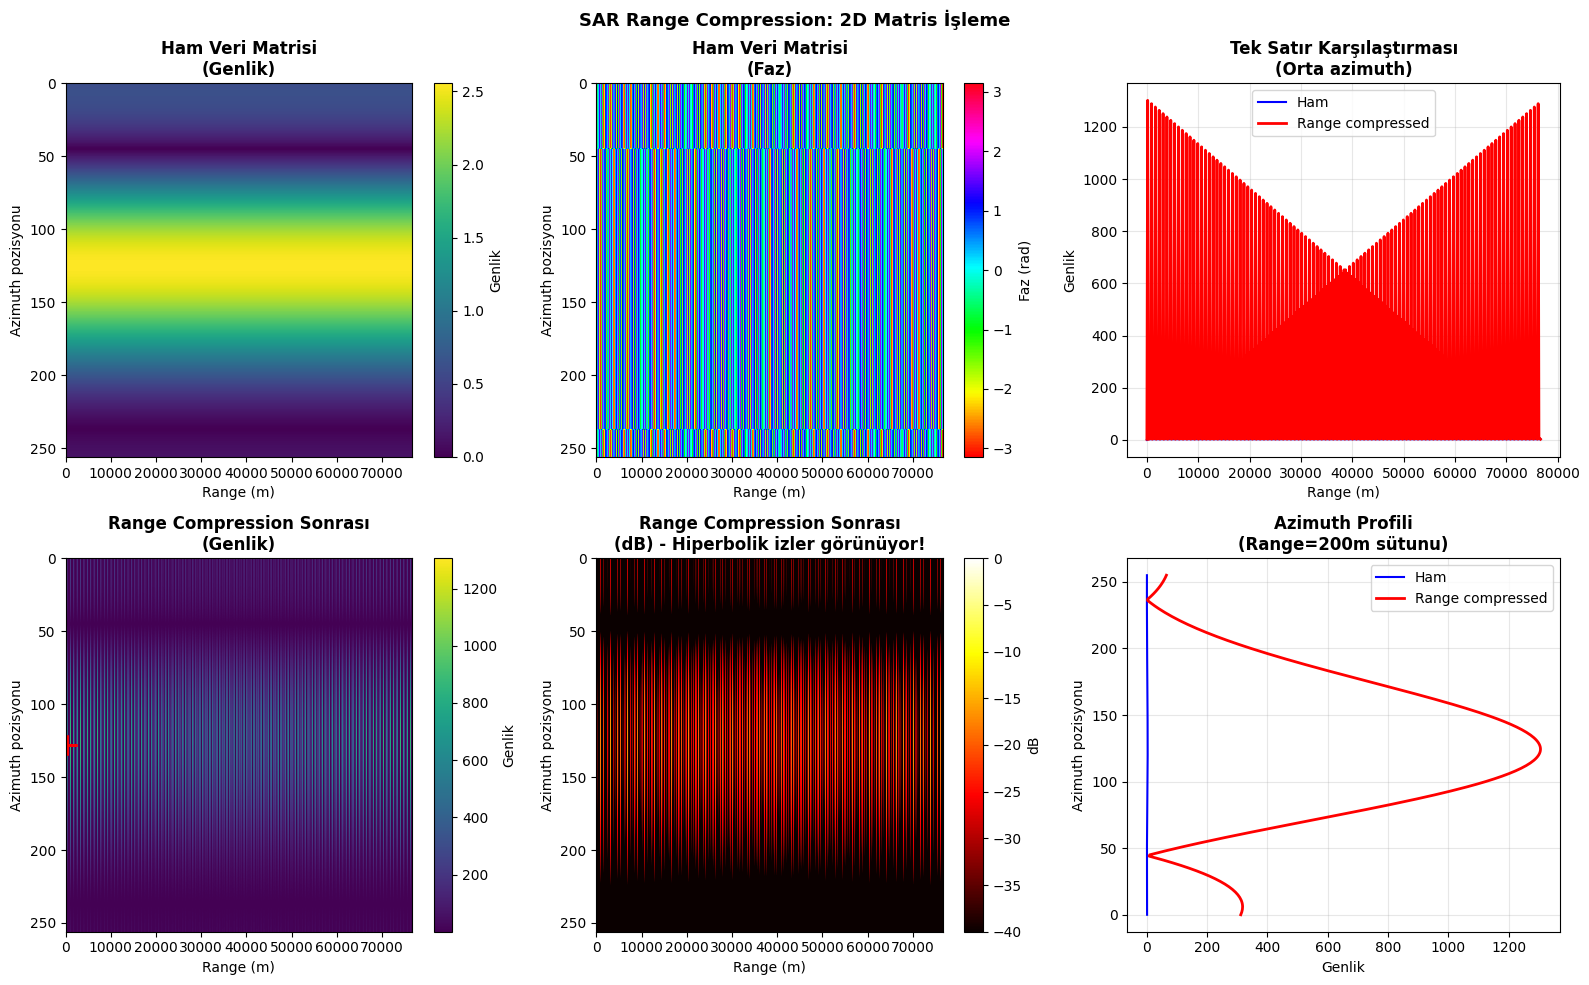


RANGE COMPRESSION ÖZET:
Ham veri boyutu:          (256, 512)
Range compressed boyutu:  (256, 512)
Her satıra uygulanan işlem: FFT → × conj(H) → IFFT
Toplam işlem sayısı:       256 matched filter

Şimdi ne görüyoruz?
→ Range yönünde: Keskin tepeler ✓
→ Azimuth yönünde: Hala hiperbolik izler var ✗
→ Sıradaki adım: Azimuth compression!


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# PARAMETRELER
# ============================================
c = 3e8
f_c = 10e9
lambda_c = c / f_c
B = 200e6
T_chirp = 1e-3
K = B / T_chirp
fs = 1e6
N_range = 512       # Her satırda kaç örnek
N_azimuth = 256     # Kaç pozisyon (satır sayısı)
v = 50              # Platform hızı

t = np.arange(N_range) / fs
range_axis = np.arange(N_range) * c / (2 * fs)

# Platform pozisyonları
y_platform = np.linspace(-100, 100, N_azimuth)

# Hedefler
targets = [
    {'range': 200, 'azimuth': 0},    # Merkez
    {'range': 250, 'azimuth': 30},   # Sağda
    {'range': 180, 'azimuth': -20},  # Solda
]

# ============================================
# HAM VERİ MATRİSİ OLUŞTUR
# ============================================
print("Ham veri matrisi oluşturuluyor...")

# Referans chirp
ref_chirp = np.exp(1j * np.pi * K * t**2)

# 2D ham veri matrisi
raw_data = np.zeros((N_azimuth, N_range), dtype=complex)

for az_idx, yp in enumerate(y_platform):
    for target in targets:
        # Anlık mesafe (hiperbolik)
        R_instant = np.sqrt(target['range']**2 + 
                           (yp - target['azimuth'])**2)
        
        # Gecikme
        delay = 2 * R_instant / c
        delay_samples = int(delay * fs)
        
        # Işın genişliği ağırlıklandırması
        angle = np.arctan((yp - target['azimuth']) / target['range'])
        beamwidth = lambda_c / 0.1
        weight = np.sinc(angle / beamwidth)
        
        if delay_samples < N_range:
            delayed = np.zeros(N_range, dtype=complex)
            delayed[delay_samples:] = ref_chirp[:N_range - delay_samples]
            raw_data[az_idx] += weight * delayed

print(f"Ham veri boyutu: {raw_data.shape}")

# ============================================
# RANGE COMPRESSION
# Her satıra matched filter uygula
# ============================================
print("Range compression uygulanıyor...")

range_compressed = np.zeros_like(raw_data)
H = np.fft.fft(ref_chirp)  # Referans chirp'in FFT'si (bir kere hesapla)

for az_idx in range(N_azimuth):
    # Bu satırın FFT'si
    S = np.fft.fft(raw_data[az_idx])
    
    # Matched filter: çarp ve IFFT
    range_compressed[az_idx] = np.fft.ifft(S * np.conj(H))

print(f"Range compressed boyutu: {range_compressed.shape}")

# ============================================
# GÖRSELLEŞTİRME
# ============================================
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Ham veri - Genlik
ax = axes[0, 0]
im = ax.imshow(np.abs(raw_data), aspect='auto', cmap='viridis',
               extent=[range_axis[0], range_axis[-1], 
                      N_azimuth, 0])
plt.colorbar(im, ax=ax, label='Genlik')
ax.set_xlabel('Range (m)')
ax.set_ylabel('Azimuth pozisyonu')
ax.set_title('Ham Veri Matrisi\n(Genlik)', fontweight='bold')

# 2. Ham veri - Faz
ax = axes[0, 1]
im = ax.imshow(np.angle(raw_data), aspect='auto', cmap='hsv',
               extent=[range_axis[0], range_axis[-1], 
                      N_azimuth, 0])
plt.colorbar(im, ax=ax, label='Faz (rad)')
ax.set_xlabel('Range (m)')
ax.set_ylabel('Azimuth pozisyonu')
ax.set_title('Ham Veri Matrisi\n(Faz)', fontweight='bold')

# 3. Ham veri - Tek satır
ax = axes[0, 2]
mid_row = N_azimuth // 2
ax.plot(range_axis, np.abs(raw_data[mid_row]), 
        'b-', linewidth=1.5, label='Ham')
ax.plot(range_axis, np.abs(range_compressed[mid_row]), 
        'r-', linewidth=2, label='Range compressed')
ax.set_xlabel('Range (m)')
ax.set_ylabel('Genlik')
ax.set_title('Tek Satır Karşılaştırması\n(Orta azimuth)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Range compressed - Genlik
ax = axes[1, 0]
im = ax.imshow(np.abs(range_compressed), aspect='auto', cmap='viridis',
               extent=[range_axis[0], range_axis[-1], 
                      N_azimuth, 0])
plt.colorbar(im, ax=ax, label='Genlik')
ax.set_xlabel('Range (m)')
ax.set_ylabel('Azimuth pozisyonu')
ax.set_title('Range Compression Sonrası\n(Genlik)', fontweight='bold')

# Hedefleri işaretle
for target in targets:
    az_center = N_azimuth // 2
    ax.plot(target['range'], az_center, 'r+', 
            markersize=15, markeredgewidth=2)

# 5. Range compressed - dB
ax = axes[1, 1]
rc_db = 20 * np.log10(np.abs(range_compressed) + 1e-10)
rc_db -= rc_db.max()
im = ax.imshow(rc_db, aspect='auto', cmap='hot',
               vmin=-40, vmax=0,
               extent=[range_axis[0], range_axis[-1], 
                      N_azimuth, 0])
plt.colorbar(im, ax=ax, label='dB')
ax.set_xlabel('Range (m)')
ax.set_ylabel('Azimuth pozisyonu')
ax.set_title('Range Compression Sonrası\n(dB) - Hiperbolik izler görünüyor!', 
             fontweight='bold')

# 6. Tek sütun - azimuth profili
ax = axes[1, 2]
range_200_idx = np.argmin(np.abs(range_axis - 200))
ax.plot(np.abs(raw_data[:, range_200_idx]), 
        range(N_azimuth), 'b-', linewidth=1.5, label='Ham')
ax.plot(np.abs(range_compressed[:, range_200_idx]), 
        range(N_azimuth), 'r-', linewidth=2, label='Range compressed')
ax.set_xlabel('Genlik')
ax.set_ylabel('Azimuth pozisyonu')
ax.set_title('Azimuth Profili\n(Range=200m sütunu)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('SAR Range Compression: 2D Matris İşleme', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================
# ÖZET
# ============================================
print("\n" + "="*55)
print("RANGE COMPRESSION ÖZET:")
print("="*55)
print(f"Ham veri boyutu:          {raw_data.shape}")
print(f"Range compressed boyutu:  {range_compressed.shape}")
print(f"Her satıra uygulanan işlem: FFT → × conj(H) → IFFT")
print(f"Toplam işlem sayısı:       {N_azimuth} matched filter")
print("="*55)
print("\nŞimdi ne görüyoruz?")
print("→ Range yönünde: Keskin tepeler ✓")
print("→ Azimuth yönünde: Hala hiperbolik izler var ✗")
print("→ Sıradaki adım: Azimuth compression!")